# Disaster Tweets data analysis

In [7]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, ensemble, model_selection, pipeline, compose, preprocessing
from keyword_transformer import KeywordTransformer
from location_transformer import LocationTransformer
from text_stats_transformer import TextStatsTransformer
# spacy.cli.download('en_core_web_sm')


In [8]:
df_train = pd.read_csv('./train.csv', index_col='id')
df_test = pd.read_csv('./test.csv', index_col='id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [9]:
df_train.sample(n=10)

,keyword,location,text,target
id,,,,
1312,bloody,Singapore,Eh hello cover your bloody thighs your bloody ...,0
9051,structural%20failure,NaN,VIDEO: Virgin Galactic crash: Brakes blamed: I...,1
248,ambulance,New York / Worldwide,Two air ambulances on scene of serious crash b...,1
6115,hellfire,"570 Vanderbilt; Brooklyn, NY",New cocktail on the list! El Diablo Mas Verde:...,0
2970,dead,Glasgow,@soapscoop i need you to confirm that ross is ...,0
3812,detonate,"Broomfield, CO",#Boulder deputies are waiting for the bomb squ...,1
1383,body%20bag,NaN,# handbags Genuine Mulberry Antony Cross Body ...,0
4534,emergency,"Melbourne, Australia",From @LeanDOTorg: Lean Thinking for Quicker Po...,0
4975,explosion,S.F. Bay area,MORE--&gt;OSHA officers on siteinvestigating N...,1


In [10]:
df_train.fillna(value={'keyword': '', 'location': ''}, inplace=True)
df_train.sample(n=10)

,keyword,location,text,target
id,,,,
657,attack,Freeport IL. USA,Horrific attack on wife by muslim in Italy htt...,1
2936,danger,Atlanta Georgia,@nuggets #FETTILOOTCH IS #SLANGLUCCI OPPRESSIO...,0
8608,seismic,Somalia,Exploration takes seismic shift in Gabon to So...,0
9319,survive,ava,In a dream you saw a way to survive and you we...,0
8035,refugees,,...//..// whao.. 12000 Nigerian refugees repat...,1
3459,derailed,"Washington, DC",Happy no one was hurt when #wmata train derail...,1
10763,wreckage,,The first piece of wreckage from the first-eve...,1
4303,dust%20storm,qosqo,Totoooooo! Totoooooooooo!\n'@Historicalmages: ...,1
9116,suicide%20bomb,,//./../.. Pic of 16yr old PKK suicide bomber w...,1


## Enrich datasets

In [11]:
transformer = compose.ColumnTransformer(transformers=[
    ('keywords', KeywordTransformer(keyword_file_name='./keywords_stats.csv'), ['keyword']),
    ('location', LocationTransformer(), ['location']),
    ('text-features', TextStatsTransformer(), ['text'])
], remainder='passthrough', verbose_feature_names_out=False, verbose=True)

In [12]:
train_enriched = transformer.fit_transform(df_train)

[ColumnTransformer] ...... (1 of 4) Processing keywords, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing location, total=  40.3s
[ColumnTransformer] . (3 of 4) Processing text-features, total=   7.7s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s


In [13]:
df_train_enriched = pd.DataFrame(data = train_enriched, columns=transformer.get_feature_names_out())

In [14]:
transformer.get_feature_names_out()

array(['keyword', 'positive_factor', 'location', 'country', 'state',
       'city', 'missing_location', 'text', 'clean_text', 'text_length',
       'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count',
       'urls_count', 'tokens_count', 'stop_words_factor',
       'clean_tokens_factor', 'target'], dtype=object)

In [17]:
df_train_enriched.to_csv('./train_enriched.csv', index_label='id')

In [18]:
test_enriched = transformer.fit_transform(df_test)
df_test_enriched = pd.DataFrame(data = test_enriched, columns=transformer.get_feature_names_out())
df_test_enriched.to_csv('./test_enriched.csv', index_label='id')

[ColumnTransformer] ...... (1 of 3) Processing keywords, total=   0.0s
[ColumnTransformer] ...... (2 of 3) Processing location, total=  15.8s
[ColumnTransformer] . (3 of 3) Processing text-features, total=   3.1s


## Features selection

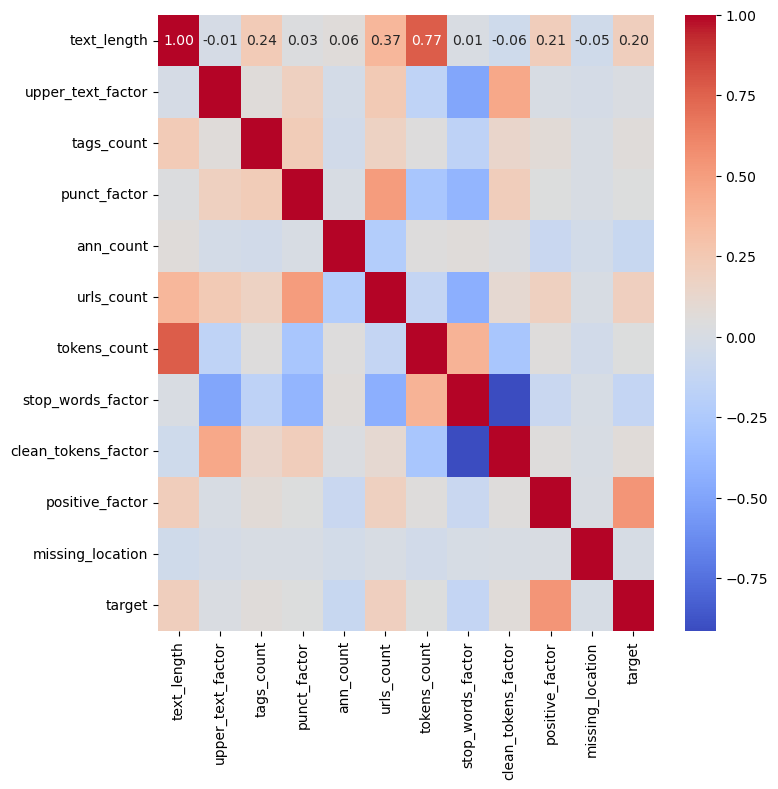

In [21]:
selected_features = ['text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 'urls_count',
                     'tokens_count', 'stop_words_factor', 'clean_tokens_factor', 'positive_factor',
                     'missing_location',
                     'target']
df_corr = df_train_enriched[selected_features].corr()

plt.figure(figsize=(9, 8))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=df_corr.columns, yticklabels=df_corr.columns)
plt.show()